# Diffraction shift correction with py4DSTEM

The code in this notebook determines the shifts of the diffraction pattern in a 4D-STEM dataset associated with the scanning of the electron beam, then corrects those shifts, outputting a new 4D data hypercube in which the shifts have been removed.

The general procedure is as follows:
1. Get vacuum probe
2. Get shifts
    * Get raw shifts
    * Fit shifts
3. Correct the shifts

In [130]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_dilation as binary_dilation
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

from time import time

In [131]:
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data(fp)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


In [167]:
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

## 1. Get the vacuum probe

The aim here is to create a convolution kernel in the shape of the unscattered electron beam, which can then be used to identify the Bragg disks in each diffraction pattern of the datacube.  We procede as follows:

* Get average vacuum probe
    * Select an ROI over (nearly) vacuum
    * Find shifts of DPs within ROI relative to one reference DP
    * Register and average all DPs in ROI
* Create vacuum probe kernel
    * Mask probe outside of central disk
    * Get probe CoM and size
    * Normalize probe to integrate to 1
    * Subtract normalized 2D gaussian to get kernel integrating to 0
    * Center kernel in Fourier space (i.e. at corners of array)

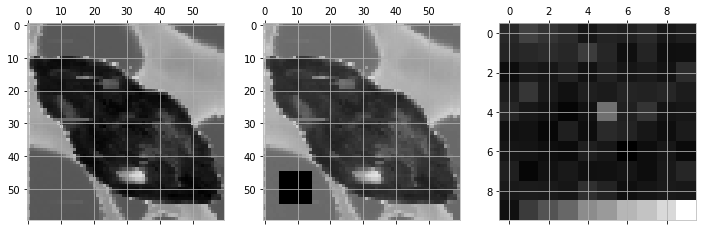

In [168]:
# ROI

xmin,xmax=45,55
ymin,ymax=5,15

im_ROI_sel = np.average(dc.data4D,axis=(2,3))
im_ROI_sel[xmin:xmax,ymin:ymax] = 0
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(im_ROI_sel,cmap='gray')
ax3.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

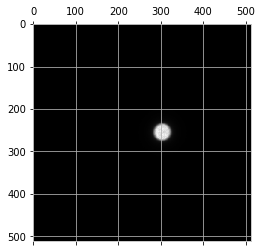

In [169]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[xmin:xmax,ymin:ymax],axis=(0,1))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [170]:
def make_Fourier_coords1D(N, pixelSize=1):
    """
    Generates 1D Fourier coordinates.
    """
    if N%2 == 0:
        q = np.roll( np.arange(-N/2,N/2)/(N*pixelSize), int(N/2))
    else:
        q = np.roll( np.arange((1-N)/2,(N+1)/2)/(N*pixelSize), int((1-N)/2))
    return q
    
def make_Fourier_coords2D(Nx, Ny, pixelSize=1):
    """
    Generates 2D Fourier coordinates.
    """
    qx = make_Fourier_coords1D(Nx,pixelSize)
    qy = make_Fourier_coords1D(Ny,pixelSize)
    qy,qx = np.meshgrid(qy,qx)
    return qx,qy

In [171]:
def get_shift(im1,im2):
    cc = np.fft.ifft2(np.fft.fft2(im1)*np.conj(np.fft.fft2(im2)))
    xshift,yshift = np.unravel_index(np.argmax(cc),dc.data4D.shape[2:4])
    return xshift,yshift

def get_shifted_im(im,xshift,yshift):
    nx,ny = np.shape(im)
    qx,qy = make_Fourier_coords2D(nx,ny,1)
    nx,ny = float(nx),float(ny)
    
    w = np.exp(-(2j*np.pi)*( (yshift*qy) + (xshift*qx) ))
    #shifted_im = np.abs(np.fft.ifft2((np.fft.fft2(im))*w))
    shifted_im = np.real(np.fft.ifft2((np.fft.fft2(im))*w))
    return shifted_im

In [172]:
def get_CoM(im):
    nx,ny=np.shape(im)
    ry,rx = np.meshgrid(np.arange(ny),np.arange(nx))
    tot_intens = np.sum(im)
    xCoM = np.sum(rx*im)/tot_intens
    yCoM = np.sum(ry*im)/tot_intens
    return xCoM,yCoM

In [173]:
# Get average shifted diffraction pattern

ref_DP = dc.data4D[xmin,ymin,:,:]

for n in range(1,(xmax-xmin)*(ymax-ymin)):
    i = xmin + n%(xmax-xmin)
    j = ymin + int(n/(xmax-xmin))
    curr_DP = dc.data4D[i,j,:,:]
    
    xshift,yshift = get_shift(ref_DP, curr_DP)
    curr_DP_shifted = get_shifted_im(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

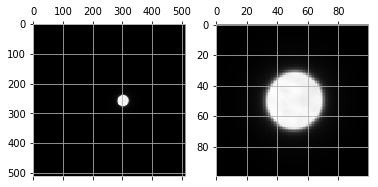

In [174]:
# Get (initial) center of mass
# Show shifted, averaged DP

xCoM_init,yCoM_init = get_CoM(ref_DP)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP,cmap='gray')
ax2.matshow(ref_DP[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
plt.show()

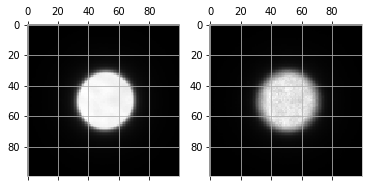

In [175]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
ax2.matshow(DP_ave_unshifted[int(xCoM_unshifted)-50:int(xCoM_unshifted)+50,int(yCoM_unshifted)-50:int(yCoM_unshifted)+50])
plt.show()

In [176]:
# Mask probe outside of central disk

mask_thresh = 0.2
mask_expansion = 12

ry,rx = np.meshgrid(dc.data4D.shape[1],dc.data4D.shape[0])
mask = ref_DP > np.max(ref_DP)*mask_thresh
mask = binary_dilation(mask,iterations=mask_expansion)

#maskDist = 0.5 + 0.5*erf(maskShift + (bwdist(~maskRound) - bwdist(bwmorph(maskRound,'dilate',1))) / (0.5*maskWidth));

probe_template = ref_DP*mask

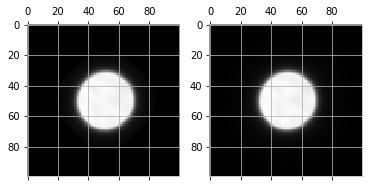

Mask alters CoM by 0.3101400088527627 pixels.


In [177]:
# Get CoM
# Compare to CoM without mask

xCoM,yCoM = get_CoM(probe_template)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
ax2.matshow(ref_DP[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
plt.show()

print("Mask alters CoM by {} pixels.".format(np.sqrt((yCoM-yCoM_init)**2+(xCoM-xCoM_init)**2)))

In [178]:
# Get probe size

r2 = (rx-xCoM)**2 + (ry-yCoM)**2
rstd = np.sum(r2*probe_template*mask) / np.sum(probe_template)

In [179]:
# Normalize probe to one
# Subtract off gaussian, to yield a kernel which integrates to zero
sigma_probe_scale = 5

probe_template_norm = probe_template/np.sum(probe_template)
subtr_gaussian = probe_template_norm - np.exp(-r2 / (2*rstd*sigma_probe_scale**2))
subtr_gaussian = subtr_gaussian/np.sum(subtr_gaussian)
probe_kernel = probe_template_norm - subtr_gaussian

print("Probe kernel sums to {}.".format(np.sum(probe_kernel)))

Probe kernel sums to -3.3306690738754696e-16.


In [180]:
# Shift probe kernel to center, then to corners
probe_kernel = get_shifted_im(probe_kernel,-xCoM,-yCoM)

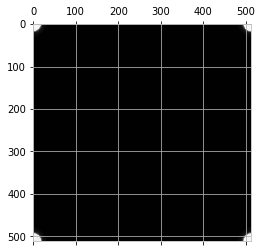

In [181]:
fig,ax=plt.subplots()
ax.matshow(probe_kernel,cmap='gray')
plt.show()

## 2. Get the diffraction shifts

In this step the relative shift of each diffraction pattern is determined, as follows:

* For one diffraction pattern, get the position of unscattered beam.
    * Convolve with the probe kernel
    * Get the positions and strengths of all bragg disks by identifying local maxima
    * Get unscattered beam using brightest local maximum (possibly with additional filtering)
* For all DPs, get the positions of unscattered beam.
    * Loop over all DPs
* Fit diffraction shifts
    * Fit plane or 2d parabaloid to unscattered beam positions

### 2a. Single diffraction pattern

* For one diffraction pattern, get the position of unscattered beam.
    * Convolve with the probe kernel
    * Get the positions and strengths of all bragg disks by identifying local maxima
    * Get unscattered beam using brightest local maximum, possibly additional filtering

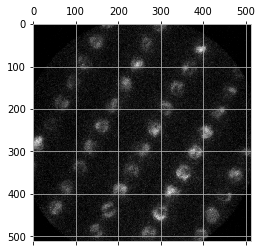

In [182]:
# Pick a test diffraction pattern
DP = dc.data4D[30,30,:,:]

fig,ax=plt.subplots()
ax.matshow(DP)
plt.show()

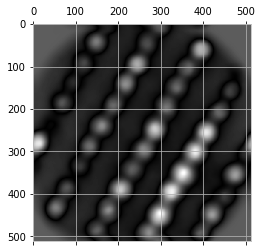

In [183]:
# Cross correlation

corrPower = 1  # Correlation type, in [0,1]. 0=phase correlation, 1=cross correlation

m = np.fft.fft2(DP) * np.conj(np.fft.fft2(probe_kernel))
cc = np.fft.ifft2(np.abs(m)**(corrPower) * np.exp(1j*np.angle(m)))

fig,ax = plt.subplots()
ax.matshow(np.abs(cc))
plt.show()

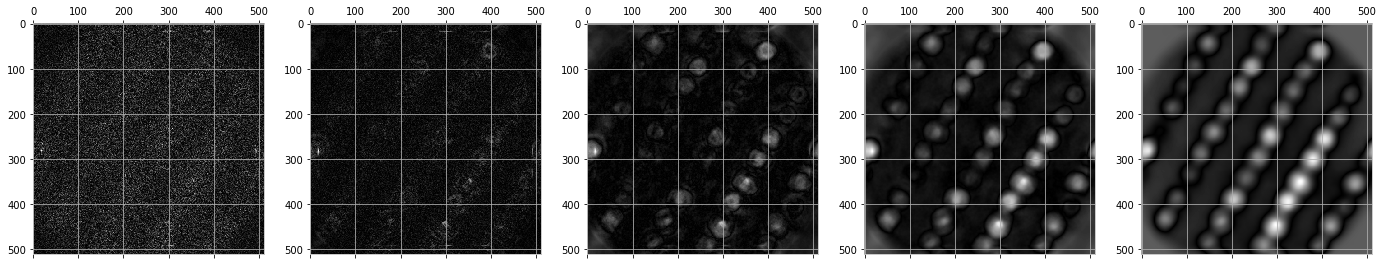

In [184]:
# Test different hybrid correlations

ccs = []
for corrPower in np.linspace(0,1,5):
    m = np.fft.fft2(DP) * np.conj(np.fft.fft2(probe_kernel))
    cc = np.fft.ifft2(np.abs(m)**(corrPower) * np.exp(1j*np.angle(m)))
    ccs.append(cc)

fig,axs = plt.subplots(1,5,figsize=(24,48))
for i in range(len(ccs)):
    axs[i].matshow(np.abs(ccs[i]))
plt.show()

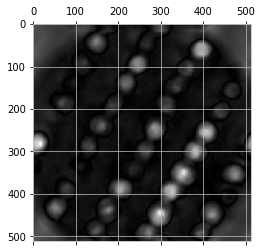

In [185]:
# Select hybrid correlation coefficient

corrPower = 0.75  # Correlation type, in [0,1]. 0=phase correlation, 1=cross correlation

m = np.fft.fft2(DP) * np.conj(np.fft.fft2(probe_kernel))
cc = np.real(np.fft.ifft2(np.abs(m)**(corrPower) * np.exp(1j*np.angle(m)))) # abs??

fig,ax = plt.subplots()
ax.matshow(np.abs(cc))
plt.show()

In [186]:
# Apply small gaussian smoothing filter

sigma_gaussianFilter = 2

cc = np.maximum(cc,0)
cc = gaussian_filter(cc, sigma_gaussianFilter)

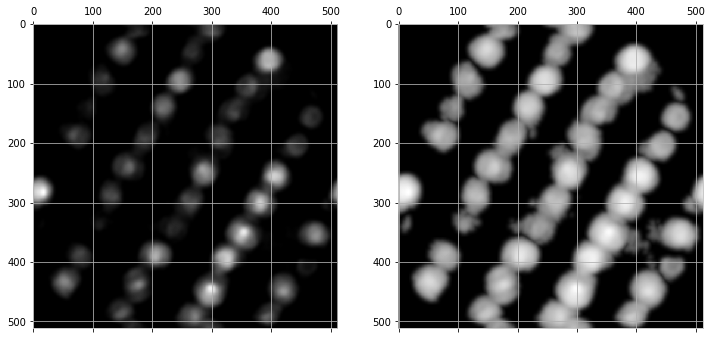

In [187]:
# Show cross correlation and log(cc)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(np.maximum(cc,0)**0.25)
plt.show()

In [188]:
# Get maximal points

def get_maximal_points(ar):
    return (ar>np.roll(ar,(-1,0),axis=(0,1))) & (ar>np.roll(ar,(1,0),axis=(0,1))) & \
           (ar>np.roll(ar,(0,-1),axis=(0,1))) & (ar>np.roll(ar,(0,1),axis=(0,1))) & \
           (ar>np.roll(ar,(-1,-1),axis=(0,1))) & (ar>np.roll(ar,(-1,1),axis=(0,1))) & \
           (ar>np.roll(ar,(1,-1),axis=(0,1))) & (ar>np.roll(ar,(1,1),axis=(0,1)))

max_points = get_maximal_points(cc)

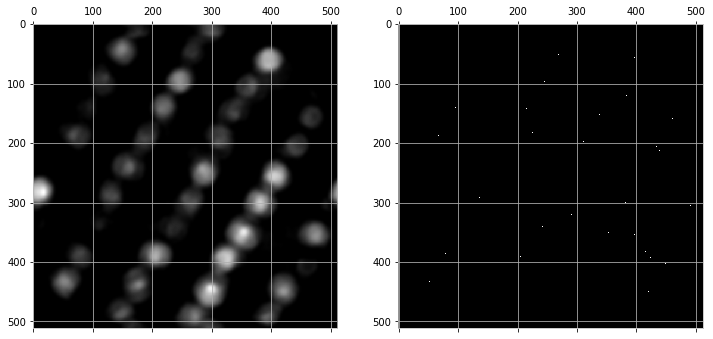

In [189]:
# Show max_points with cross correlation

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(max_points)
plt.show()

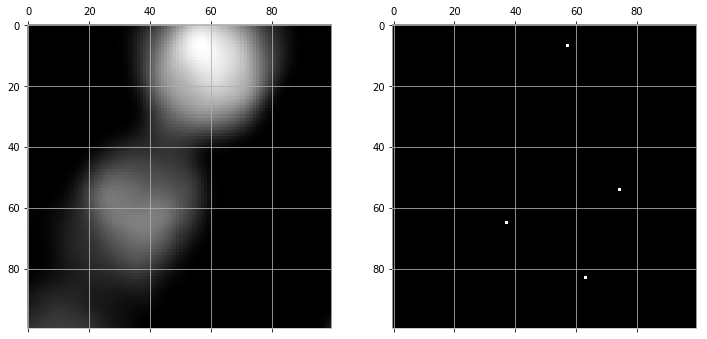

In [190]:
# Zoom in

xc,yc = get_CoM(cc)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc[int(xc)-50:int(xc)+50,int(yc)-50:int(yc)+50])
ax2.matshow(max_points[int(xc)-50:int(xc)+50,int(yc)-50:int(yc)+50])
plt.show()

In [191]:
edge_boundary = 20

max_points[:edge_boundary,:]=False
max_points[-edge_boundary:,:]=False
max_points[:,:edge_boundary]=False
max_points[:,-edge_boundary:]=False    

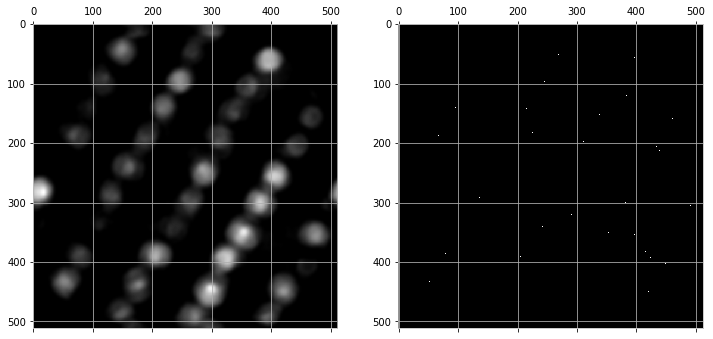

In [192]:
# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.matshow(cc)
ax2.matshow(max_points)
plt.show()

In [193]:
# Make point_list

maxNumPeaks = 45

max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
point_intensities = cc[max_point_indices_x,max_point_indices_y]

# Better: use a structured np array, then sort by column of interest
numPeaks = min(maxNumPeaks, len(point_intensities))
peaks_point_list = np.empty((3,numPeaks))
max_indices = np.argsort(-point_intensities)

peaks_point_list[0,:] = max_point_indices_x[max_indices[:numPeaks]]
peaks_point_list[1,:] = max_point_indices_y[max_indices[:numPeaks]]
peaks_point_list[2,:] = point_intensities[max_indices[:numPeaks]]

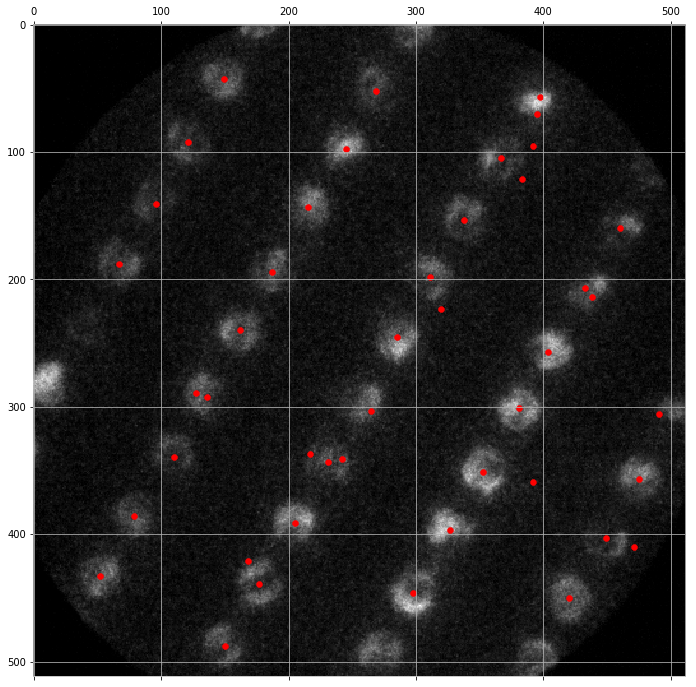

In [194]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(DP)
ax.scatter(peaks_point_list[1,:],peaks_point_list[0,:],color='r')
plt.show()

In [195]:
# Remove peaks that are too close together

minPeakSpacing = 32

r2 = minPeakSpacing**2
deletePeaks = np.zeros(numPeaks,dtype=bool)
for i in range(numPeaks):
    if deletePeaks[i] == False:
        tooClose = ( (peaks_point_list[0,:]-peaks_point_list[0,i])**2 + \
                  (peaks_point_list[1,:]-peaks_point_list[1,i])**2 ) < r2
        tooClose[:i+1] = False
        deletePeaks[tooClose] = True
peaks_point_list = np.delete(peaks_point_list, deletePeaks.nonzero()[0], 1)

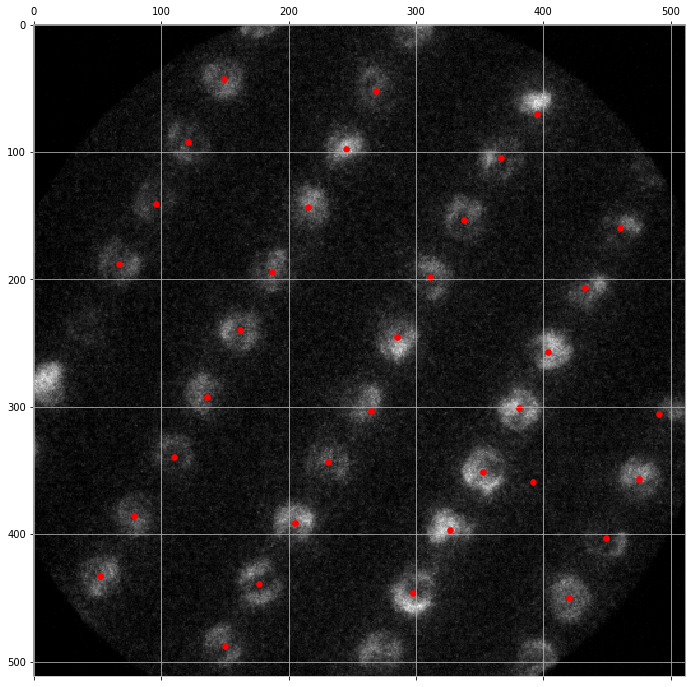

In [196]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(DP)
ax.scatter(peaks_point_list[1,:],peaks_point_list[0,:],color='r')
plt.show()

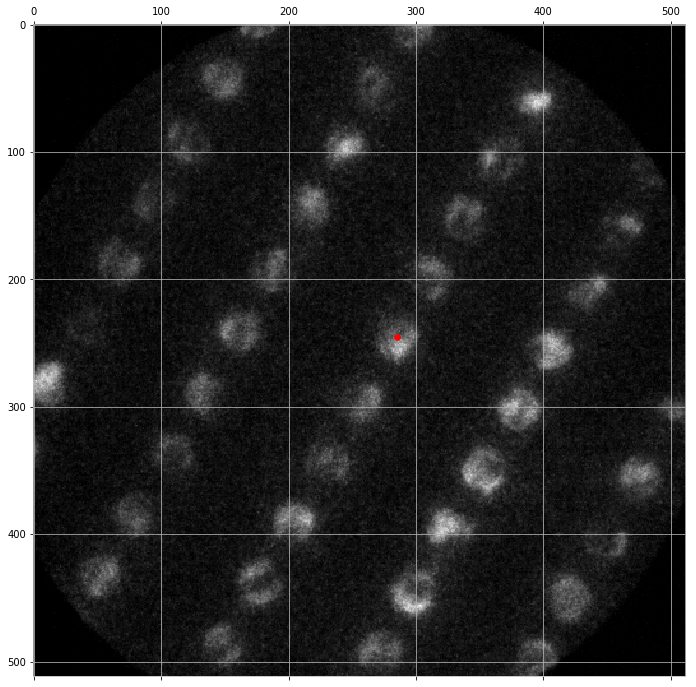

In [197]:
# Find center peak
# TODO: deconvolution + autocorrelation

center_score = peaks_point_list[2,:] / \
               np.sqrt( (peaks_point_list[0,:]-xCoM)**2 + \
                 (peaks_point_list[1,:]-yCoM)**2  )
center_peak_ind = center_score.argmax()

center_peak_x = peaks_point_list[0,center_peak_ind]
center_peak_y = peaks_point_list[1,center_peak_ind]

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(DP)
ax.scatter(center_peak_y,center_peak_x,color='r')
plt.show()

### 2b. Get diffraction shifts for all DPs

* For all DPs, get the positions of unscattered beam.
    * Loop over all DPs

In [198]:
corrPower = 0.75
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 60
minPeakSpacing = 32

diffraction_shifts = np.empty((2,dc.R_Nx,dc.R_Ny))


t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel))
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(i,j))

        # Get diffraction pattern
        DP = dc.data4D[i,j,:,:]
        
        # Cross correlation
        m = np.fft.fft2(DP) * probe_kernel_FT
        cc = np.real(np.fft.ifft2(np.abs(m)**(corrPower) * np.exp(1j*np.angle(m)))) # abs??

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make list of peak locations and intensities
        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        numPeaks = min(maxNumPeaks, len(point_intensities))
        peaks_list = np.empty((3,numPeaks))
        max_indices = np.argsort(-point_intensities)

        peaks_list[0,:] = max_point_indices_x[max_indices[:numPeaks]]
        peaks_list[1,:] = max_point_indices_y[max_indices[:numPeaks]]
        peaks_list[2,:] = point_intensities[max_indices[:numPeaks]]
        
        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for k in range(numPeaks):
            if deletePeaks[k] == False:
                tooClose = ( (peaks_list[0,:]-peaks_list[0,k])**2 + \
                          (peaks_list[1,:]-peaks_list[1,k])**2 ) < r2
                tooClose[:k+1] = False
                deletePeaks[tooClose] = True
        peaks_list = np.delete(peaks_list, deletePeaks.nonzero()[0], 1)
        
        # Find center peak
        center_score = peaks_list[2,:] / \
                       np.sqrt( (peaks_list[0,:]-xCoM)**2 + \
                         (peaks_list[1,:]-yCoM)**2  )
        center_peak_ind = center_score.argmax()
        
        diffraction_shifts[0,i,j] = peaks_list[0,center_peak_ind]
        diffraction_shifts[1,i,j] = peaks_list[1,center_peak_ind]
        
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 4,47
Analyzing scan position 4,48
Analyzing scan position 4,49
Analyzing scan position 4,50
Analyzing scan position 4,51
Analyzing scan position 4,52
Analyzing scan position 4,53
Analyzing scan position 4,54
Analyzing scan position 4,55
Analyzing scan position 4,56
Analyzing scan position 4,57
Analyzing scan position 4,58
Analyzing scan position 4,59
Analyzing scan position 5,0
Analyzing scan position 5,1
Analyzing scan position 5,2
Analyzing scan position 5,3
Analyzing scan position 5,4
Analyzing scan position 5,5
Analyzing scan position 5,6
Analyzing scan position 5,7
Analyzing scan position 5,8
Analyzing scan position 5,9
Analyzing scan position 5,10
Analyzing scan position 5,11
Analyzing scan position 5,12
Analyzing scan position 5,13
Analyzing scan position 5,14
Analyzing scan position 5,15
Analyzing scan position 5,16
Analyzing scan position 5,17
Analyzing scan position 5,18
Analyzing scan position 5,19
Analyzing scan position 5,20
Analyzing scan position 

Analyzing scan position 9,33
Analyzing scan position 9,34
Analyzing scan position 9,35
Analyzing scan position 9,36
Analyzing scan position 9,37
Analyzing scan position 9,38
Analyzing scan position 9,39
Analyzing scan position 9,40
Analyzing scan position 9,41
Analyzing scan position 9,42
Analyzing scan position 9,43
Analyzing scan position 9,44
Analyzing scan position 9,45
Analyzing scan position 9,46
Analyzing scan position 9,47
Analyzing scan position 9,48
Analyzing scan position 9,49
Analyzing scan position 9,50
Analyzing scan position 9,51
Analyzing scan position 9,52
Analyzing scan position 9,53
Analyzing scan position 9,54
Analyzing scan position 9,55
Analyzing scan position 9,56
Analyzing scan position 9,57
Analyzing scan position 9,58
Analyzing scan position 9,59
Analyzing scan position 10,0
Analyzing scan position 10,1
Analyzing scan position 10,2
Analyzing scan position 10,3
Analyzing scan position 10,4
Analyzing scan position 10,5
Analyzing scan position 10,6
Analyzing scan

Analyzing scan position 14,9
Analyzing scan position 14,10
Analyzing scan position 14,11
Analyzing scan position 14,12
Analyzing scan position 14,13
Analyzing scan position 14,14
Analyzing scan position 14,15
Analyzing scan position 14,16
Analyzing scan position 14,17
Analyzing scan position 14,18
Analyzing scan position 14,19
Analyzing scan position 14,20
Analyzing scan position 14,21
Analyzing scan position 14,22
Analyzing scan position 14,23
Analyzing scan position 14,24
Analyzing scan position 14,25
Analyzing scan position 14,26
Analyzing scan position 14,27
Analyzing scan position 14,28
Analyzing scan position 14,29
Analyzing scan position 14,30
Analyzing scan position 14,31
Analyzing scan position 14,32
Analyzing scan position 14,33
Analyzing scan position 14,34
Analyzing scan position 14,35
Analyzing scan position 14,36
Analyzing scan position 14,37
Analyzing scan position 14,38
Analyzing scan position 14,39
Analyzing scan position 14,40
Analyzing scan position 14,41
Analyzing s

Analyzing scan position 18,44
Analyzing scan position 18,45
Analyzing scan position 18,46
Analyzing scan position 18,47
Analyzing scan position 18,48
Analyzing scan position 18,49
Analyzing scan position 18,50
Analyzing scan position 18,51
Analyzing scan position 18,52
Analyzing scan position 18,53
Analyzing scan position 18,54
Analyzing scan position 18,55
Analyzing scan position 18,56
Analyzing scan position 18,57
Analyzing scan position 18,58
Analyzing scan position 18,59
Analyzing scan position 19,0
Analyzing scan position 19,1
Analyzing scan position 19,2
Analyzing scan position 19,3
Analyzing scan position 19,4
Analyzing scan position 19,5
Analyzing scan position 19,6
Analyzing scan position 19,7
Analyzing scan position 19,8
Analyzing scan position 19,9
Analyzing scan position 19,10
Analyzing scan position 19,11
Analyzing scan position 19,12
Analyzing scan position 19,13
Analyzing scan position 19,14
Analyzing scan position 19,15
Analyzing scan position 19,16
Analyzing scan posit

Analyzing scan position 23,20
Analyzing scan position 23,21
Analyzing scan position 23,22
Analyzing scan position 23,23
Analyzing scan position 23,24
Analyzing scan position 23,25
Analyzing scan position 23,26
Analyzing scan position 23,27
Analyzing scan position 23,28
Analyzing scan position 23,29
Analyzing scan position 23,30
Analyzing scan position 23,31
Analyzing scan position 23,32
Analyzing scan position 23,33
Analyzing scan position 23,34
Analyzing scan position 23,35
Analyzing scan position 23,36
Analyzing scan position 23,37
Analyzing scan position 23,38
Analyzing scan position 23,39
Analyzing scan position 23,40
Analyzing scan position 23,41
Analyzing scan position 23,42
Analyzing scan position 23,43
Analyzing scan position 23,44
Analyzing scan position 23,45
Analyzing scan position 23,46
Analyzing scan position 23,47
Analyzing scan position 23,48
Analyzing scan position 23,49
Analyzing scan position 23,50
Analyzing scan position 23,51
Analyzing scan position 23,52
Analyzing 

Analyzing scan position 27,57
Analyzing scan position 27,58
Analyzing scan position 27,59
Analyzing scan position 28,0
Analyzing scan position 28,1
Analyzing scan position 28,2
Analyzing scan position 28,3
Analyzing scan position 28,4
Analyzing scan position 28,5
Analyzing scan position 28,6
Analyzing scan position 28,7
Analyzing scan position 28,8
Analyzing scan position 28,9
Analyzing scan position 28,10
Analyzing scan position 28,11
Analyzing scan position 28,12
Analyzing scan position 28,13
Analyzing scan position 28,14
Analyzing scan position 28,15
Analyzing scan position 28,16
Analyzing scan position 28,17
Analyzing scan position 28,18
Analyzing scan position 28,19
Analyzing scan position 28,20
Analyzing scan position 28,21
Analyzing scan position 28,22
Analyzing scan position 28,23
Analyzing scan position 28,24
Analyzing scan position 28,25
Analyzing scan position 28,26
Analyzing scan position 28,27
Analyzing scan position 28,28
Analyzing scan position 28,29
Analyzing scan posit

Analyzing scan position 32,34
Analyzing scan position 32,35
Analyzing scan position 32,36
Analyzing scan position 32,37
Analyzing scan position 32,38
Analyzing scan position 32,39
Analyzing scan position 32,40
Analyzing scan position 32,41
Analyzing scan position 32,42
Analyzing scan position 32,43
Analyzing scan position 32,44
Analyzing scan position 32,45
Analyzing scan position 32,46
Analyzing scan position 32,47
Analyzing scan position 32,48
Analyzing scan position 32,49
Analyzing scan position 32,50
Analyzing scan position 32,51
Analyzing scan position 32,52
Analyzing scan position 32,53
Analyzing scan position 32,54
Analyzing scan position 32,55
Analyzing scan position 32,56
Analyzing scan position 32,57
Analyzing scan position 32,58
Analyzing scan position 32,59
Analyzing scan position 33,0
Analyzing scan position 33,1
Analyzing scan position 33,2
Analyzing scan position 33,3
Analyzing scan position 33,4
Analyzing scan position 33,5
Analyzing scan position 33,6
Analyzing scan po

Analyzing scan position 37,11
Analyzing scan position 37,12
Analyzing scan position 37,13
Analyzing scan position 37,14
Analyzing scan position 37,15
Analyzing scan position 37,16
Analyzing scan position 37,17
Analyzing scan position 37,18
Analyzing scan position 37,19
Analyzing scan position 37,20
Analyzing scan position 37,21
Analyzing scan position 37,22
Analyzing scan position 37,23
Analyzing scan position 37,24
Analyzing scan position 37,25
Analyzing scan position 37,26
Analyzing scan position 37,27
Analyzing scan position 37,28
Analyzing scan position 37,29
Analyzing scan position 37,30
Analyzing scan position 37,31
Analyzing scan position 37,32
Analyzing scan position 37,33
Analyzing scan position 37,34
Analyzing scan position 37,35
Analyzing scan position 37,36
Analyzing scan position 37,37
Analyzing scan position 37,38
Analyzing scan position 37,39
Analyzing scan position 37,40
Analyzing scan position 37,41
Analyzing scan position 37,42
Analyzing scan position 37,43
Analyzing 

Analyzing scan position 41,48
Analyzing scan position 41,49
Analyzing scan position 41,50
Analyzing scan position 41,51
Analyzing scan position 41,52
Analyzing scan position 41,53
Analyzing scan position 41,54
Analyzing scan position 41,55
Analyzing scan position 41,56
Analyzing scan position 41,57
Analyzing scan position 41,58
Analyzing scan position 41,59
Analyzing scan position 42,0
Analyzing scan position 42,1
Analyzing scan position 42,2
Analyzing scan position 42,3
Analyzing scan position 42,4
Analyzing scan position 42,5
Analyzing scan position 42,6
Analyzing scan position 42,7
Analyzing scan position 42,8
Analyzing scan position 42,9
Analyzing scan position 42,10
Analyzing scan position 42,11
Analyzing scan position 42,12
Analyzing scan position 42,13
Analyzing scan position 42,14
Analyzing scan position 42,15
Analyzing scan position 42,16
Analyzing scan position 42,17
Analyzing scan position 42,18
Analyzing scan position 42,19
Analyzing scan position 42,20
Analyzing scan posit

Analyzing scan position 46,24
Analyzing scan position 46,25
Analyzing scan position 46,26
Analyzing scan position 46,27
Analyzing scan position 46,28
Analyzing scan position 46,29
Analyzing scan position 46,30
Analyzing scan position 46,31
Analyzing scan position 46,32
Analyzing scan position 46,33
Analyzing scan position 46,34
Analyzing scan position 46,35
Analyzing scan position 46,36
Analyzing scan position 46,37
Analyzing scan position 46,38
Analyzing scan position 46,39
Analyzing scan position 46,40
Analyzing scan position 46,41
Analyzing scan position 46,42
Analyzing scan position 46,43
Analyzing scan position 46,44
Analyzing scan position 46,45
Analyzing scan position 46,46
Analyzing scan position 46,47
Analyzing scan position 46,48
Analyzing scan position 46,49
Analyzing scan position 46,50
Analyzing scan position 46,51
Analyzing scan position 46,52
Analyzing scan position 46,53
Analyzing scan position 46,54
Analyzing scan position 46,55
Analyzing scan position 46,56
Analyzing 

Analyzing scan position 51,1
Analyzing scan position 51,2
Analyzing scan position 51,3
Analyzing scan position 51,4
Analyzing scan position 51,5
Analyzing scan position 51,6
Analyzing scan position 51,7
Analyzing scan position 51,8
Analyzing scan position 51,9
Analyzing scan position 51,10
Analyzing scan position 51,11
Analyzing scan position 51,12
Analyzing scan position 51,13
Analyzing scan position 51,14
Analyzing scan position 51,15
Analyzing scan position 51,16
Analyzing scan position 51,17
Analyzing scan position 51,18
Analyzing scan position 51,19
Analyzing scan position 51,20
Analyzing scan position 51,21
Analyzing scan position 51,22
Analyzing scan position 51,23
Analyzing scan position 51,24
Analyzing scan position 51,25
Analyzing scan position 51,26
Analyzing scan position 51,27
Analyzing scan position 51,28
Analyzing scan position 51,29
Analyzing scan position 51,30
Analyzing scan position 51,31
Analyzing scan position 51,32
Analyzing scan position 51,33
Analyzing scan posi

Analyzing scan position 55,39
Analyzing scan position 55,40
Analyzing scan position 55,41
Analyzing scan position 55,42
Analyzing scan position 55,43
Analyzing scan position 55,44
Analyzing scan position 55,45
Analyzing scan position 55,46
Analyzing scan position 55,47
Analyzing scan position 55,48
Analyzing scan position 55,49
Analyzing scan position 55,50
Analyzing scan position 55,51
Analyzing scan position 55,52
Analyzing scan position 55,53
Analyzing scan position 55,54
Analyzing scan position 55,55
Analyzing scan position 55,56
Analyzing scan position 55,57
Analyzing scan position 55,58
Analyzing scan position 55,59
Analyzing scan position 56,0
Analyzing scan position 56,1
Analyzing scan position 56,2
Analyzing scan position 56,3
Analyzing scan position 56,4
Analyzing scan position 56,5
Analyzing scan position 56,6
Analyzing scan position 56,7
Analyzing scan position 56,8
Analyzing scan position 56,9
Analyzing scan position 56,10
Analyzing scan position 56,11
Analyzing scan posit

In [199]:
# Subtract off average

diffraction_shifts[0,:,:]=diffraction_shifts[0,:,:]-np.average(diffraction_shifts[0,:,:])
diffraction_shifts[1,:,:]=diffraction_shifts[1,:,:]-np.average(diffraction_shifts[1,:,:])

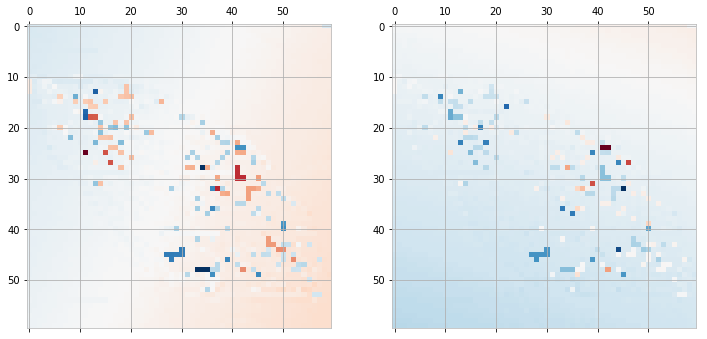

In [200]:
# Plot shifts

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,18))
ax1.matshow(diffraction_shifts[0,:,:],cmap="RdBu")
ax2.matshow(diffraction_shifts[1,:,:],cmap="RdBu")
plt.show()

### 2c. Fit diffraction shifts

* Fit plane (or polynomial/Bezier surface) to unscattered beam positions

In [201]:
def plane(xy, mx, my, b):
    return mx*xy[0] + my*xy[1] +b

In [202]:
# Make simulated data

mx,my,b = -5,3,0.5

x,y = np.linspace(0,10,100),np.linspace(0,10,100)
ry,rx = np.meshgrid(y,x)

shape=rx.shape
rx_1D = rx.reshape((1,np.prod(shape)))
ry_1D = ry.reshape((1,np.prod(shape)))
xy = np.vstack((rx_1D, ry_1D))

data = plane(xy,mx,my,b)
data_noisy = data + np.random.normal(0,1,len(data))
data_2D = data.reshape(shape)
data_noisy_2D = data_noisy.reshape(shape)

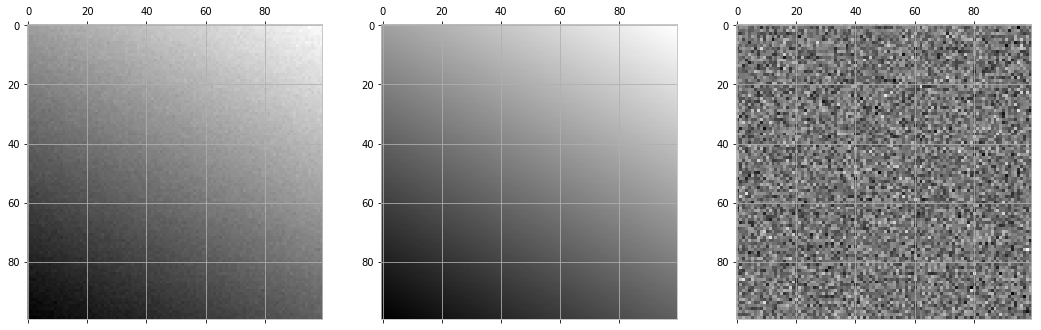

Fit vals: mx=-5.003509161290419, my=2.996432742037512, b=0.5256037874193604


In [203]:
# Fit simulated data

popt_guess = (-1,1,0)

popt, pcov = curve_fit(plane, xy, data_noisy)
data_fit = plane(xy, *popt)
data_fit_2D = data_fit.reshape(shape)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(18,10))
ax1.matshow(data_noisy_2D)
ax2.matshow(data_fit_2D)
ax3.matshow(data_fit_2D - data_noisy_2D)
plt.show()

print("Fit vals: mx={}, my={}, b={}".format(popt[0],popt[1],popt[2]))

In [204]:
# Fit diffraction shifts

shape = diffraction_shifts[0,:,:].shape
x,y = np.arange(shape[1]),np.arange(shape[0])
ry,rx = np.meshgrid(y,x)
rx_1D = rx.reshape((1,np.prod(shape)))
ry_1D = ry.reshape((1,np.prod(shape)))
xy = np.vstack((rx_1D, ry_1D))

diffraction_shifts_x_1D = diffraction_shifts[0,:,:].reshape(np.prod(shape))
diffraction_shifts_y_1D = diffraction_shifts[1,:,:].reshape(np.prod(shape))

popt_x, pcov_x = curve_fit(plane, xy, diffraction_shifts_x_1D)
popt_y, pcov_y = curve_fit(plane, xy, diffraction_shifts_y_1D)

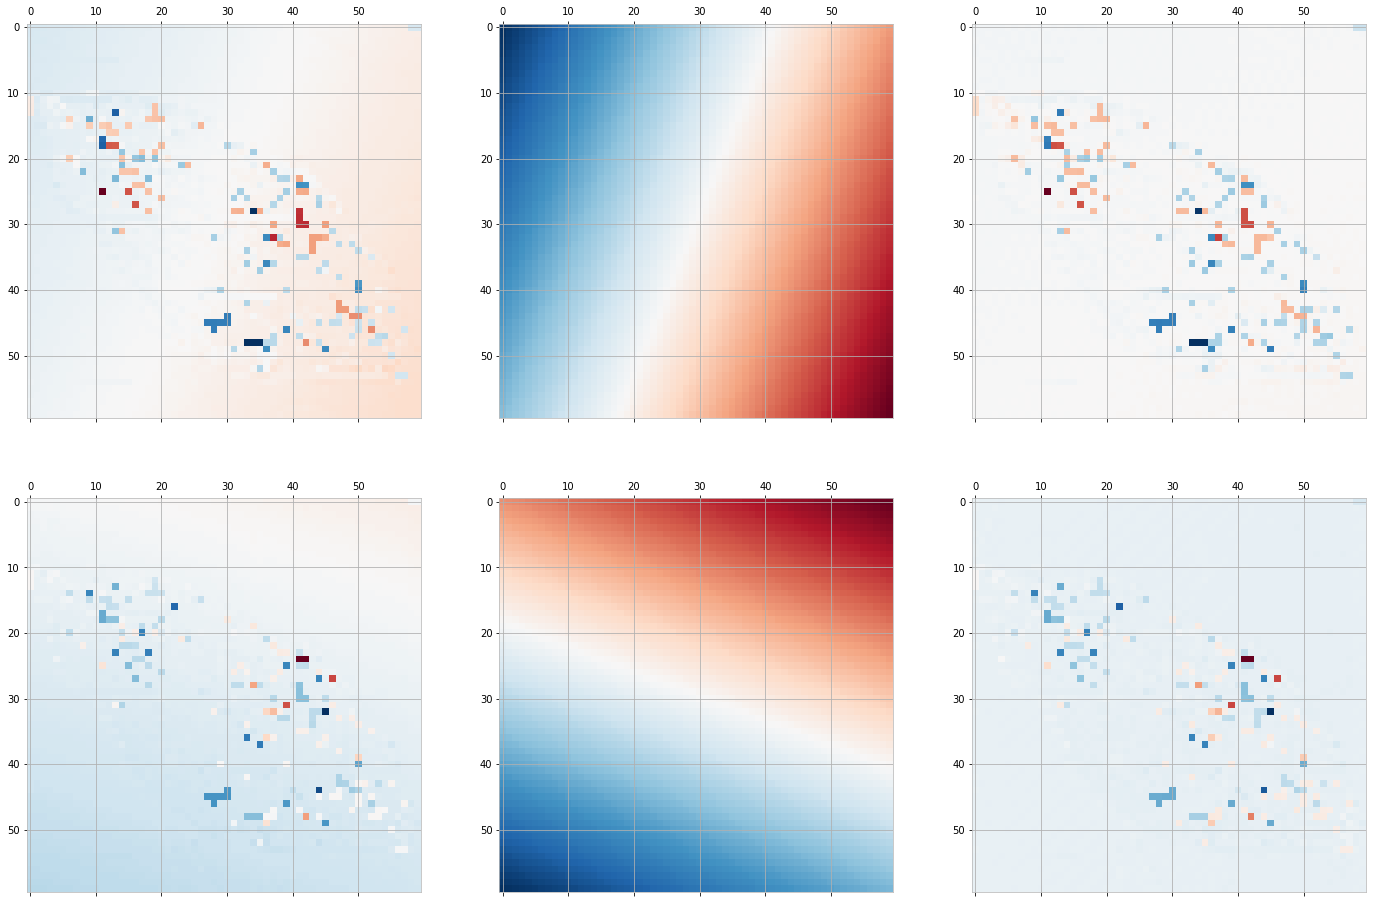

In [205]:
# Get shifts by position, and show residuals

diffraction_shifts_x_2D = plane(xy,*popt_x).reshape(shape)
diffraction_shifts_y_2D = plane(xy,*popt_y).reshape(shape)

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts[0,:,:],cmap="RdBu")
ax12.matshow(diffraction_shifts_x_2D,cmap="RdBu")
ax13.matshow(diffraction_shifts[0,:,:]-diffraction_shifts_x_2D,cmap="RdBu")
ax21.matshow(diffraction_shifts[1,:,:],cmap="RdBu")
ax22.matshow(diffraction_shifts_y_2D,cmap="RdBu")
ax23.matshow(diffraction_shifts[1,:,:]-diffraction_shifts_y_2D,cmap="RdBu")
plt.show()

## 3. Correct the diffraction shifts

Finally, the diffraction pattern at each scan position is corrected for the calculated shifts.

* Apply shifts at each beam positions, and save new, processed datacube

In [206]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = get_shifted_im(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_x_2D[i,j],
                                                   -diffraction_shifts_y_2D[i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 0,10
Shifting DP from scan position 0,11
Shifting DP from scan position 0,12
Shifting DP from scan position 0,13
Shifting DP from scan position 0,14
Shifting DP from scan position 0,15
Shifting DP from scan position 0,16
Shifting DP from scan position 0,17
Shifting DP from scan position 0,18
Shifting DP from scan position 0,19
Shifting DP from scan position 0,20
Shifting DP from scan position 0,21
Shifting DP from scan position 0,22
Shifting DP from scan position 0,23
Shifting DP from scan position 0,24
Shifting DP from scan position 0,25
Shifting DP from scan position 0,26
Shifting DP from scan position 0,27
Sh

Shifting DP from scan position 3,53
Shifting DP from scan position 3,54
Shifting DP from scan position 3,55
Shifting DP from scan position 3,56
Shifting DP from scan position 3,57
Shifting DP from scan position 3,58
Shifting DP from scan position 3,59
Shifting DP from scan position 4,0
Shifting DP from scan position 4,1
Shifting DP from scan position 4,2
Shifting DP from scan position 4,3
Shifting DP from scan position 4,4
Shifting DP from scan position 4,5
Shifting DP from scan position 4,6
Shifting DP from scan position 4,7
Shifting DP from scan position 4,8
Shifting DP from scan position 4,9
Shifting DP from scan position 4,10
Shifting DP from scan position 4,11
Shifting DP from scan position 4,12
Shifting DP from scan position 4,13
Shifting DP from scan position 4,14
Shifting DP from scan position 4,15
Shifting DP from scan position 4,16
Shifting DP from scan position 4,17
Shifting DP from scan position 4,18
Shifting DP from scan position 4,19
Shifting DP from scan position 4,20
Sh

Shifting DP from scan position 7,43
Shifting DP from scan position 7,44
Shifting DP from scan position 7,45
Shifting DP from scan position 7,46
Shifting DP from scan position 7,47
Shifting DP from scan position 7,48
Shifting DP from scan position 7,49
Shifting DP from scan position 7,50
Shifting DP from scan position 7,51
Shifting DP from scan position 7,52
Shifting DP from scan position 7,53
Shifting DP from scan position 7,54
Shifting DP from scan position 7,55
Shifting DP from scan position 7,56
Shifting DP from scan position 7,57
Shifting DP from scan position 7,58
Shifting DP from scan position 7,59
Shifting DP from scan position 8,0
Shifting DP from scan position 8,1
Shifting DP from scan position 8,2
Shifting DP from scan position 8,3
Shifting DP from scan position 8,4
Shifting DP from scan position 8,5
Shifting DP from scan position 8,6
Shifting DP from scan position 8,7
Shifting DP from scan position 8,8
Shifting DP from scan position 8,9
Shifting DP from scan position 8,10
Sh

Shifting DP from scan position 11,35
Shifting DP from scan position 11,36
Shifting DP from scan position 11,37
Shifting DP from scan position 11,38
Shifting DP from scan position 11,39
Shifting DP from scan position 11,40
Shifting DP from scan position 11,41
Shifting DP from scan position 11,42
Shifting DP from scan position 11,43
Shifting DP from scan position 11,44
Shifting DP from scan position 11,45
Shifting DP from scan position 11,46
Shifting DP from scan position 11,47
Shifting DP from scan position 11,48
Shifting DP from scan position 11,49
Shifting DP from scan position 11,50
Shifting DP from scan position 11,51
Shifting DP from scan position 11,52
Shifting DP from scan position 11,53
Shifting DP from scan position 11,54
Shifting DP from scan position 11,55
Shifting DP from scan position 11,56
Shifting DP from scan position 11,57
Shifting DP from scan position 11,58
Shifting DP from scan position 11,59
Shifting DP from scan position 12,0
Shifting DP from scan position 12,1
Shi

Shifting DP from scan position 15,18
Shifting DP from scan position 15,19
Shifting DP from scan position 15,20
Shifting DP from scan position 15,21
Shifting DP from scan position 15,22
Shifting DP from scan position 15,23
Shifting DP from scan position 15,24
Shifting DP from scan position 15,25
Shifting DP from scan position 15,26
Shifting DP from scan position 15,27
Shifting DP from scan position 15,28
Shifting DP from scan position 15,29
Shifting DP from scan position 15,30
Shifting DP from scan position 15,31
Shifting DP from scan position 15,32
Shifting DP from scan position 15,33
Shifting DP from scan position 15,34
Shifting DP from scan position 15,35
Shifting DP from scan position 15,36
Shifting DP from scan position 15,37
Shifting DP from scan position 15,38
Shifting DP from scan position 15,39
Shifting DP from scan position 15,40
Shifting DP from scan position 15,41
Shifting DP from scan position 15,42
Shifting DP from scan position 15,43
Shifting DP from scan position 15,44
S

Shifting DP from scan position 19,2
Shifting DP from scan position 19,3
Shifting DP from scan position 19,4
Shifting DP from scan position 19,5
Shifting DP from scan position 19,6
Shifting DP from scan position 19,7
Shifting DP from scan position 19,8
Shifting DP from scan position 19,9
Shifting DP from scan position 19,10
Shifting DP from scan position 19,11
Shifting DP from scan position 19,12
Shifting DP from scan position 19,13
Shifting DP from scan position 19,14
Shifting DP from scan position 19,15
Shifting DP from scan position 19,16
Shifting DP from scan position 19,17
Shifting DP from scan position 19,18
Shifting DP from scan position 19,19
Shifting DP from scan position 19,20
Shifting DP from scan position 19,21
Shifting DP from scan position 19,22
Shifting DP from scan position 19,23
Shifting DP from scan position 19,24
Shifting DP from scan position 19,25
Shifting DP from scan position 19,26
Shifting DP from scan position 19,27
Shifting DP from scan position 19,28
Shifting 

Shifting DP from scan position 22,47
Shifting DP from scan position 22,48
Shifting DP from scan position 22,49
Shifting DP from scan position 22,50
Shifting DP from scan position 22,51
Shifting DP from scan position 22,52
Shifting DP from scan position 22,53
Shifting DP from scan position 22,54
Shifting DP from scan position 22,55
Shifting DP from scan position 22,56
Shifting DP from scan position 22,57
Shifting DP from scan position 22,58
Shifting DP from scan position 22,59
Shifting DP from scan position 23,0
Shifting DP from scan position 23,1
Shifting DP from scan position 23,2
Shifting DP from scan position 23,3
Shifting DP from scan position 23,4
Shifting DP from scan position 23,5
Shifting DP from scan position 23,6
Shifting DP from scan position 23,7
Shifting DP from scan position 23,8
Shifting DP from scan position 23,9
Shifting DP from scan position 23,10
Shifting DP from scan position 23,11
Shifting DP from scan position 23,12
Shifting DP from scan position 23,13
Shifting DP

Shifting DP from scan position 26,33
Shifting DP from scan position 26,34
Shifting DP from scan position 26,35
Shifting DP from scan position 26,36
Shifting DP from scan position 26,37
Shifting DP from scan position 26,38
Shifting DP from scan position 26,39
Shifting DP from scan position 26,40
Shifting DP from scan position 26,41
Shifting DP from scan position 26,42
Shifting DP from scan position 26,43
Shifting DP from scan position 26,44
Shifting DP from scan position 26,45
Shifting DP from scan position 26,46
Shifting DP from scan position 26,47
Shifting DP from scan position 26,48
Shifting DP from scan position 26,49
Shifting DP from scan position 26,50
Shifting DP from scan position 26,51
Shifting DP from scan position 26,52
Shifting DP from scan position 26,53
Shifting DP from scan position 26,54
Shifting DP from scan position 26,55
Shifting DP from scan position 26,56
Shifting DP from scan position 26,57
Shifting DP from scan position 26,58
Shifting DP from scan position 26,59
S

Shifting DP from scan position 30,18
Shifting DP from scan position 30,19
Shifting DP from scan position 30,20
Shifting DP from scan position 30,21
Shifting DP from scan position 30,22
Shifting DP from scan position 30,23
Shifting DP from scan position 30,24
Shifting DP from scan position 30,25
Shifting DP from scan position 30,26
Shifting DP from scan position 30,27
Shifting DP from scan position 30,28
Shifting DP from scan position 30,29
Shifting DP from scan position 30,30
Shifting DP from scan position 30,31
Shifting DP from scan position 30,32
Shifting DP from scan position 30,33
Shifting DP from scan position 30,34
Shifting DP from scan position 30,35
Shifting DP from scan position 30,36
Shifting DP from scan position 30,37
Shifting DP from scan position 30,38
Shifting DP from scan position 30,39
Shifting DP from scan position 30,40
Shifting DP from scan position 30,41
Shifting DP from scan position 30,42
Shifting DP from scan position 30,43
Shifting DP from scan position 30,44
S

Shifting DP from scan position 34,5
Shifting DP from scan position 34,6
Shifting DP from scan position 34,7
Shifting DP from scan position 34,8
Shifting DP from scan position 34,9
Shifting DP from scan position 34,10
Shifting DP from scan position 34,11
Shifting DP from scan position 34,12
Shifting DP from scan position 34,13
Shifting DP from scan position 34,14
Shifting DP from scan position 34,15
Shifting DP from scan position 34,16
Shifting DP from scan position 34,17
Shifting DP from scan position 34,18
Shifting DP from scan position 34,19
Shifting DP from scan position 34,20
Shifting DP from scan position 34,21
Shifting DP from scan position 34,22
Shifting DP from scan position 34,23
Shifting DP from scan position 34,24
Shifting DP from scan position 34,25
Shifting DP from scan position 34,26
Shifting DP from scan position 34,27
Shifting DP from scan position 34,28
Shifting DP from scan position 34,29
Shifting DP from scan position 34,30
Shifting DP from scan position 34,31
Shifti

Shifting DP from scan position 37,50
Shifting DP from scan position 37,51
Shifting DP from scan position 37,52
Shifting DP from scan position 37,53
Shifting DP from scan position 37,54
Shifting DP from scan position 37,55
Shifting DP from scan position 37,56
Shifting DP from scan position 37,57
Shifting DP from scan position 37,58
Shifting DP from scan position 37,59
Shifting DP from scan position 38,0
Shifting DP from scan position 38,1
Shifting DP from scan position 38,2
Shifting DP from scan position 38,3
Shifting DP from scan position 38,4
Shifting DP from scan position 38,5
Shifting DP from scan position 38,6
Shifting DP from scan position 38,7
Shifting DP from scan position 38,8
Shifting DP from scan position 38,9
Shifting DP from scan position 38,10
Shifting DP from scan position 38,11
Shifting DP from scan position 38,12
Shifting DP from scan position 38,13
Shifting DP from scan position 38,14
Shifting DP from scan position 38,15
Shifting DP from scan position 38,16
Shifting DP

Shifting DP from scan position 41,33
Shifting DP from scan position 41,34
Shifting DP from scan position 41,35
Shifting DP from scan position 41,36
Shifting DP from scan position 41,37
Shifting DP from scan position 41,38
Shifting DP from scan position 41,39
Shifting DP from scan position 41,40
Shifting DP from scan position 41,41
Shifting DP from scan position 41,42
Shifting DP from scan position 41,43
Shifting DP from scan position 41,44
Shifting DP from scan position 41,45
Shifting DP from scan position 41,46
Shifting DP from scan position 41,47
Shifting DP from scan position 41,48
Shifting DP from scan position 41,49
Shifting DP from scan position 41,50
Shifting DP from scan position 41,51
Shifting DP from scan position 41,52
Shifting DP from scan position 41,53
Shifting DP from scan position 41,54
Shifting DP from scan position 41,55
Shifting DP from scan position 41,56
Shifting DP from scan position 41,57
Shifting DP from scan position 41,58
Shifting DP from scan position 41,59
S

Shifting DP from scan position 45,21
Shifting DP from scan position 45,22
Shifting DP from scan position 45,23
Shifting DP from scan position 45,24
Shifting DP from scan position 45,25
Shifting DP from scan position 45,26
Shifting DP from scan position 45,27
Shifting DP from scan position 45,28
Shifting DP from scan position 45,29
Shifting DP from scan position 45,30
Shifting DP from scan position 45,31
Shifting DP from scan position 45,32
Shifting DP from scan position 45,33
Shifting DP from scan position 45,34
Shifting DP from scan position 45,35
Shifting DP from scan position 45,36
Shifting DP from scan position 45,37
Shifting DP from scan position 45,38
Shifting DP from scan position 45,39
Shifting DP from scan position 45,40
Shifting DP from scan position 45,41
Shifting DP from scan position 45,42
Shifting DP from scan position 45,43
Shifting DP from scan position 45,44
Shifting DP from scan position 45,45
Shifting DP from scan position 45,46
Shifting DP from scan position 45,47
S

Shifting DP from scan position 49,6
Shifting DP from scan position 49,7
Shifting DP from scan position 49,8
Shifting DP from scan position 49,9
Shifting DP from scan position 49,10
Shifting DP from scan position 49,11
Shifting DP from scan position 49,12
Shifting DP from scan position 49,13
Shifting DP from scan position 49,14
Shifting DP from scan position 49,15
Shifting DP from scan position 49,16
Shifting DP from scan position 49,17
Shifting DP from scan position 49,18
Shifting DP from scan position 49,19
Shifting DP from scan position 49,20
Shifting DP from scan position 49,21
Shifting DP from scan position 49,22
Shifting DP from scan position 49,23
Shifting DP from scan position 49,24
Shifting DP from scan position 49,25
Shifting DP from scan position 49,26
Shifting DP from scan position 49,27
Shifting DP from scan position 49,28
Shifting DP from scan position 49,29
Shifting DP from scan position 49,30
Shifting DP from scan position 49,31
Shifting DP from scan position 49,32
Shift

Shifting DP from scan position 52,49
Shifting DP from scan position 52,50
Shifting DP from scan position 52,51
Shifting DP from scan position 52,52
Shifting DP from scan position 52,53
Shifting DP from scan position 52,54
Shifting DP from scan position 52,55
Shifting DP from scan position 52,56
Shifting DP from scan position 52,57
Shifting DP from scan position 52,58
Shifting DP from scan position 52,59
Shifting DP from scan position 53,0
Shifting DP from scan position 53,1
Shifting DP from scan position 53,2
Shifting DP from scan position 53,3
Shifting DP from scan position 53,4
Shifting DP from scan position 53,5
Shifting DP from scan position 53,6
Shifting DP from scan position 53,7
Shifting DP from scan position 53,8
Shifting DP from scan position 53,9
Shifting DP from scan position 53,10
Shifting DP from scan position 53,11
Shifting DP from scan position 53,12
Shifting DP from scan position 53,13
Shifting DP from scan position 53,14
Shifting DP from scan position 53,15
Shifting DP

Shifting DP from scan position 56,32
Shifting DP from scan position 56,33
Shifting DP from scan position 56,34
Shifting DP from scan position 56,35
Shifting DP from scan position 56,36
Shifting DP from scan position 56,37
Shifting DP from scan position 56,38
Shifting DP from scan position 56,39
Shifting DP from scan position 56,40
Shifting DP from scan position 56,41
Shifting DP from scan position 56,42
Shifting DP from scan position 56,43
Shifting DP from scan position 56,44
Shifting DP from scan position 56,45
Shifting DP from scan position 56,46
Shifting DP from scan position 56,47
Shifting DP from scan position 56,48
Shifting DP from scan position 56,49
Shifting DP from scan position 56,50
Shifting DP from scan position 56,51
Shifting DP from scan position 56,52
Shifting DP from scan position 56,53
Shifting DP from scan position 56,54
Shifting DP from scan position 56,55
Shifting DP from scan position 56,56
Shifting DP from scan position 56,57
Shifting DP from scan position 56,58
S

In [207]:
# Save
dc.data4D = data4D_corrected
fp="/Users/Ben/Desktop/example.h5"
py4DSTEM.readwrite.save_from_datacube(dc,fp)

Creating file /Users/Ben/Desktop/example.h5...
Writing metadata...
Done.
